In [1]:
import cv2
import numpy as np
import matplotlib
from matplotlib import pyplot as plt


(902, 654, 3)


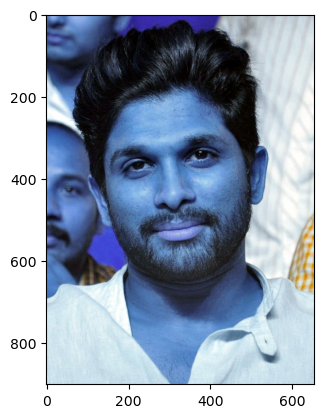

In [2]:
img=cv2.imread("./dataset/allu-arjun/13.jpg")
print(img.shape)
plt.imshow(img)
plt.show()

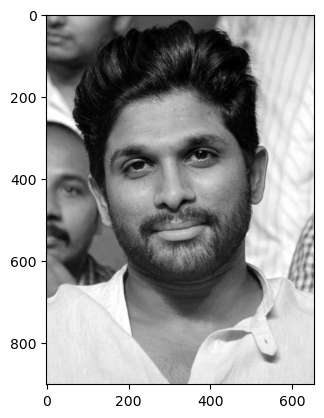

In [3]:
img_gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
img_gray.shape
plt.imshow(img_gray,cmap='gray')
plt.show()

In [4]:
# opencv haar cascade classifier
face_cascade=cv2.CascadeClassifier('./opencv/haarcascade_frontalface_default.xml')
eye_cascade=cv2.CascadeClassifier('./opencv/haarcascade_eye.xml')

In [5]:
# Testing crop face on single image
faces = face_cascade.detectMultiScale(img_gray, 1.3, 5)
for (x,y,w,h) in faces:
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = img_gray[y:y+h, x:x+w]
    roi_color = img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2) 
cv2.imshow('img',img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [6]:
# taking only faces where both eyes are detected 
# manually deleted face images other than classifying image
def crop_face(image_path):
    dets=[]
    img=cv2.imread(image_path)
    if img is None:
        return dets
    img_gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(img_gray, 1.3, 5)
    
    for (x,y,w,h) in faces:
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
        roi_gray = img_gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes)>=2:
            dets.append(roi_color)
    return dets
            


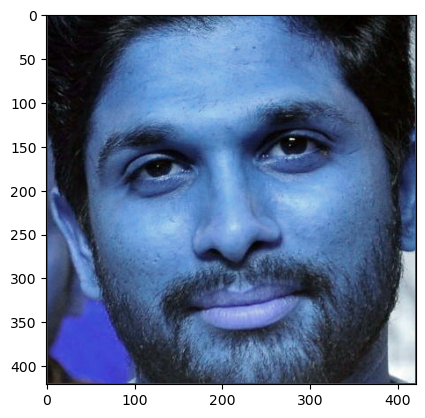

In [7]:
crop_images=crop_face('./dataset/allu-arjun/13.jpg')
if len(crop_images)>0:
    for img in crop_images:
        plt.imshow(img)
        plt.show()

In [92]:
# Apllying crop face to all images in the dataset

import os 

artist_folders=os.listdir('./dataset')
cropping_folder='./cropped_dataset/'
dataset_dir='./dataset/'
for folder in artist_folders:
     count=0
     if os.path.isdir(dataset_dir+folder):
        img_paths=os.listdir(dataset_dir+folder)
        for img_path in img_paths:
            crop_images=crop_face(dataset_dir+folder+"/"+img_path)
            if len(crop_images)>0:
                for x in crop_images:
                    crop_img_path=cropping_folder+folder+"/"+str(count)+".jpg"
                    if not os.path.isdir(cropping_folder+folder):
                        os.makedirs(cropping_folder+folder)
                    cv2.imwrite(crop_img_path,x)
                    count=count+1
            
            
            


In [8]:
# Using Wavelet transform as a feature

import numpy as np
import pywt 
import cv2
img=crop_images[0]

def w2d(img,mode='haar',level=1):
    imArray=img

    imArray=cv2.cvtColor(imArray,cv2.COLOR_RGB2GRAY)
    imArray=np.float32(imArray)
  
    imArray=imArray/255
    # compute coeeficients
    coeffs=pywt.wavedec2(imArray,mode,level=level)
    coeffs_H=list(coeffs)
    coeffs_H[0]*=0
    # recontruct 
    imArray_H=pywt.waverec2(coeffs_H,mode)
    imArray_H*=255
    imArray_H=np.uint8(imArray_H)
    # print(imArray)
    #print(imArray_H)
    # plt.imshow(imArray_H,cmap='gray')
    # plt.show()
    # plt.imshow(imArray)
    # plt.show()
    return imArray_H


In [10]:
# Allocation of numbers to all classes present in datet direcotry 
artist_class={}
cropping_folder='./cropped_dataset/'
count=0
for folder in os.listdir(cropping_folder):
    artist_class[folder]=count
    count=count+1
print(artist_class)



{'allu-arjun': 0, 'chiranjeevi': 1, 'mahesh-babu': 2, 'ntr-jr': 3, 'prabhas': 4}


In [24]:
#using wavelet transfrom features along with image to get better accuracy in svm 

X=[]
Y=[]
sz=64
cropped_folders=os.listdir(cropping_folder)
for folders in cropped_folders:
    if os.path.isdir(cropping_folder+folders):
        image_paths=os.listdir(cropping_folder+folders)
        for img_path in image_paths:
            img=cv2.imread(cropping_folder+folders+"/"+img_path)
            # print(cropping_folder+folders+"/"+img_path)
            scaled_img=cv2.resize(img,(sz,sz))
            img_har=w2d(img,'db1',5)
            scaled_img_har=cv2.resize(img_har,(sz,sz))
            combined_img=np.vstack((scaled_img.reshape(sz*sz*3,1),scaled_img_har.reshape(sz*sz,1)))
            X.append(combined_img)
            Y.append(artist_class[folders])
            
    
    


In [25]:
print(len(X[0]))
print(len(Y))
X=np.array(X).reshape(len(X),len(X[0])).astype(np.float32)
print(X.shape)


16384
455
(455, 16384)


In [26]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, Y,train_size=0.8,test_size=0.2, random_state=0)

model_svm = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'linear',gamma='auto',C = 10,probability=True))])
model_svm.fit(X_train, y_train)
model_svm.score(X_test, y_test)

0.8241758241758241

In [28]:
from sklearn.ensemble import RandomForestClassifier

model_rf=RandomForestClassifier(n_estimators=100,random_state=0)
model_rf.fit(X_train,y_train)
model_rf.score(X_test,y_test)


0.7032967032967034

In [29]:
from sklearn.linear_model import LogisticRegression

model_lr=LogisticRegression(solver='liblinear',multi_class='auto',C=1)
model_lr.fit(X_train,y_train)
model_lr.score(X_test,y_test)

0.7582417582417582

In [30]:
from sklearn.metrics import confusion_matrix
cm_svm = confusion_matrix(y_test, model_svm.predict(X_test))
cm_rf = confusion_matrix(y_test, model_rf.predict(X_test))
cm_lr = confusion_matrix(y_test, model_lr.predict(X_test))

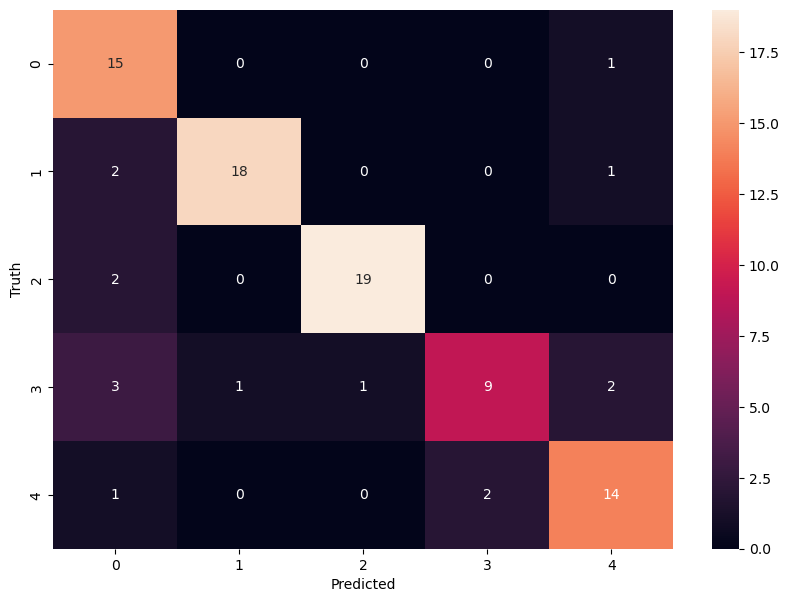

In [31]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm_svm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

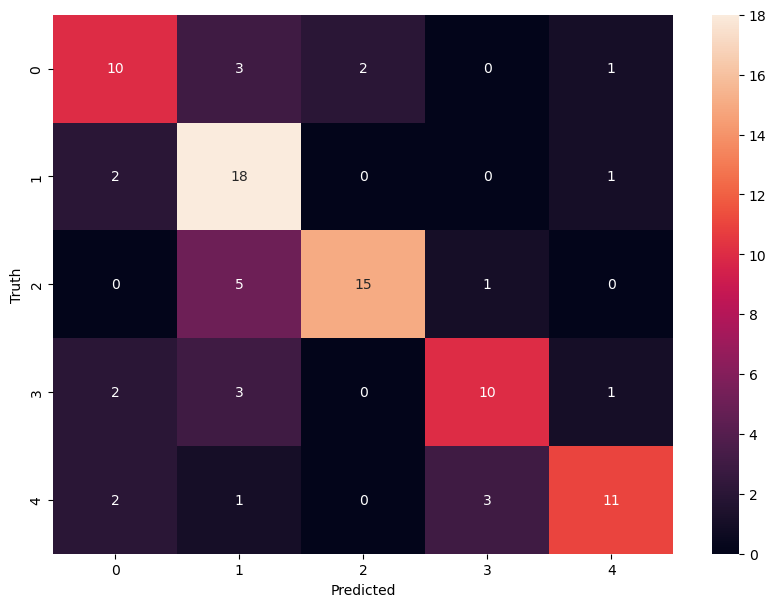

In [32]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm_rf, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

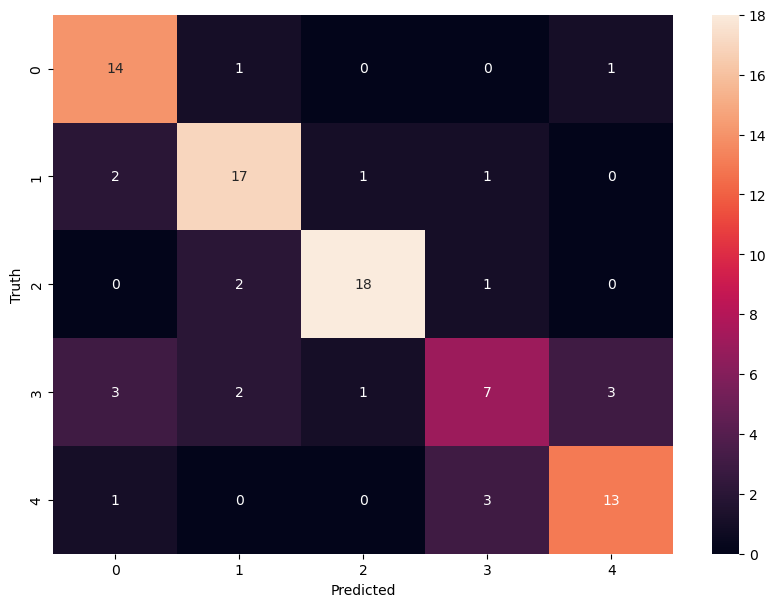

In [33]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm_lr, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [37]:
import joblib 
# Save the model as a pickle in a file 
joblib.dump(model_svm, 'saved_model.pkl') 

['saved_model.pkl']

In [38]:
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(artist_class))